In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np 
from numpy import log
import gmaps 
import gmaps.datasets 
import matplotlib.pyplot as plt
from datetime import datetime
plt.style.use('ggplot')
from sorted_months_weekdays import Month_Sorted_Month

# Arima class
from statsmodels.compat.pandas import Appender

import warnings

from sklearn.model_selection import TimeSeriesSplit
from sklearn.cluster import KMeans

from mpl_toolkits.mplot3d import Axes3D

from statsmodels.tools.data import _is_using_pandas
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.statespace.kalman_filter import MEMORY_CONSERVE
from statsmodels.tsa.statespace.tools import diff
import statsmodels.base.wrapper as wrap
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima.estimators.yule_walker import yule_walker
from statsmodels.tsa.arima.estimators.burg import burg
from statsmodels.tsa.arima.estimators.hannan_rissanen import hannan_rissanen
from statsmodels.tsa.arima.estimators.innovations import (
    innovations, innovations_mle)
from statsmodels.tsa.arima.estimators.gls import gls as estimate_gls

from statsmodels.tsa.arima.specification import SARIMAXSpecification
import statsmodels.api
import statsmodels as sm
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

import itertools


<h4>Load Electrical Consumption Data</h4>

In [2]:
# load non stationary consumption data from EDA notebook (not diffed)
not_diffed = pd.read_csv('stationary-data/not_diffed.csv').set_index('Date')

<h4>Perform Trend-Seasonal-Residual decomposition</h4>

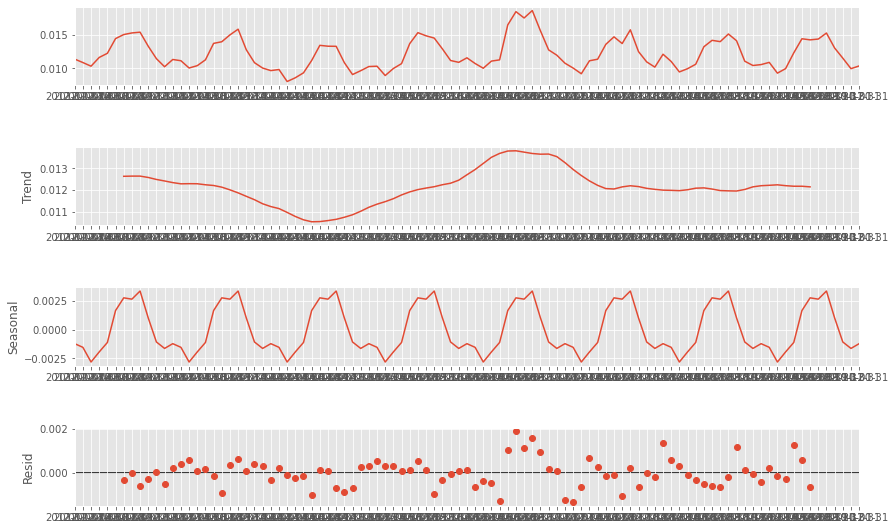

In [3]:
res = sm.tsa.seasonal_decompose(not_diffed,period=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.savefig('images/seas_decomp_not_diffed.png')

<h4>Split the data into training and testing sets</h4>

In [4]:
#train_test_split with difference = 0
tr_start,tr_end = '2012-02-28','2018-05-31'
te_start,te_end = '2018-06-30','2020-01-31'
train_0 = not_diffed[tr_start:tr_end]
test_0 = not_diffed[te_start:te_end]

<h4>Scope the AR (p) and MA (q) terms with ACF plot</h4>

/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


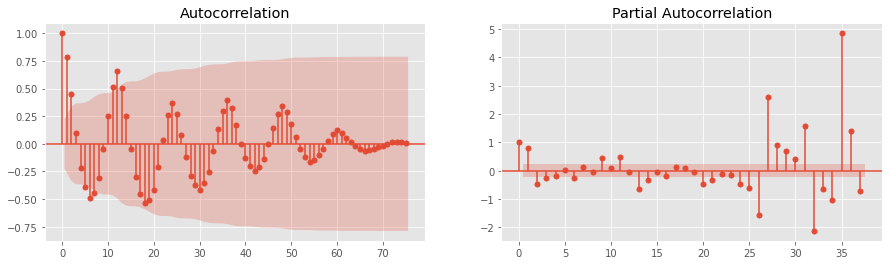

In [5]:
# SARIMAX AC and PAC not diffed

fig, ax = plt.subplots(1, 2, figsize=(15,4))
fig = sm.graphics.tsa.plot_acf(train_0, lags=75, ax=ax[0])

fig = sm.graphics.tsa.plot_pacf(train_0, lags=37, ax=ax[1])
#plt.show()
plt.savefig('images/AC_PAC_functions.png')

<h4>Run gridsearch to find optimal parameters</h4>

In [6]:
# Find optimized parameters for SARIMAX not diffed

#set parameter range
p = range(0,3)
q = range(1,3)
d = range(1,2)
s = range(1,12)
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))
# SARIMA model pipeline
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_0,
                                    order=param,
                                    seasonal_order=param_seasonal)
            results = mod.fit(max_iter = 50, method = 'powell')

            print('SARIMAX{},{} - AIC:{}'.format(param, param_seasonal, results.aic)) 
        except:
            continue

/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.828894
         Iterations: 3
         Function evaluations: 203
SARIMAX(0, 1, 1),(0, 1, 1, 2) - AIC:-727.9919116056177
Optimization terminated successfully.
         Current function value: -4.774503
         Iterations: 3
         Function evaluations: 165
SARIMAX(0, 1, 1),(0, 1, 1, 3) - AIC:-719.7244531860701
Optimization terminated successfully.
         Current function value: -4.690192
         Iterations: 3
         Function evaluations: 177
SARIMAX(0, 1, 1),(0, 1, 1, 4) - AIC:-706.9091629996036


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.579294
         Iterations: 3
         Function evaluations: 163
SARIMAX(0, 1, 1),(0, 1, 1, 5) - AIC:-690.0527589776942
Optimization terminated successfully.
         Current function value: -4.587235
         Iterations: 3
         Function evaluations: 174
SARIMAX(0, 1, 1),(0, 1, 1, 6) - AIC:-691.2597760135354
Optimization terminated successfully.
         Current function value: -4.415818
         Iterations: 4
         Function evaluations: 215


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

SARIMAX(0, 1, 1),(0, 1, 1, 7) - AIC:-665.2044036909035
Optimization terminated successfully.
         Current function value: -4.357835
         Iterations: 4
         Function evaluations: 230
SARIMAX(0, 1, 1),(0, 1, 1, 8) - AIC:-656.3909757360381


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.286464
         Iterations: 4
         Function evaluations: 225
SARIMAX(0, 1, 1),(0, 1, 1, 9) - AIC:-645.5424988890478
Optimization terminated successfully.
         Current function value: -4.178651
         Iterations: 3
         Function evaluations: 177
SARIMAX(0, 1, 1),(0, 1, 1, 10) - AIC:-629.1549997198949


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.171895
         Iterations: 3
         Function evaluations: 170
SARIMAX(0, 1, 1),(0, 1, 1, 11) - AIC:-628.1279942508968
Optimization terminated successfully.
         Current function value: -4.806402
         Iterations: 6
         Function evaluations: 420
SARIMAX(0, 1, 1),(0, 1, 2, 2) - AIC:-722.57316619847


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.796525
         Iterations: 3
         Function evaluations: 186
SARIMAX(0, 1, 1),(0, 1, 2, 3) - AIC:-721.0717795101234
Optimization terminated successfully.
         Current function value: -4.816646
         Iterations: 4
         Function evaluations: 265
SARIMAX(0, 1, 1),(0, 1, 2, 4) - AIC:-724.1301684755117


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.579426
         Iterations: 3
         Function evaluations: 210
SARIMAX(0, 1, 1),(0, 1, 2, 5) - AIC:-688.0726924519109


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.720091
         Iterations: 4
         Function evaluations: 308
SARIMAX(0, 1, 1),(0, 1, 2, 6) - AIC:-709.4539047399843
Optimization terminated successfully.
         Current function value: -4.415697
         Iterations: 4
         Function evaluations: 287


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

SARIMAX(0, 1, 1),(0, 1, 2, 7) - AIC:-663.1859502698002
Optimization terminated successfully.
         Current function value: -4.448431
         Iterations: 5
         Function evaluations: 316
SARIMAX(0, 1, 1),(0, 1, 2, 8) - AIC:-668.161437098804


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.286684
         Iterations: 3
         Function evaluations: 215
SARIMAX(0, 1, 1),(0, 1, 2, 9) - AIC:-643.575943852807


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.199768
         Iterations: 3
         Function evaluations: 218
SARIMAX(0, 1, 1),(0, 1, 2, 10) - AIC:-630.3646958982421


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


Optimization terminated successfully.
         Current function value: -4.173916
         Iterations: 4
         Function evaluations: 274
SARIMAX(0, 1, 1),(0, 1, 2, 11) - AIC:-626.4352723702556
Optimization terminated successfully.
         Current function value: -4.833894
         Iterations: 3
         Function evaluations: 210
SARIMAX(0, 1, 1),(1, 1, 1, 2) - AIC:-726.7518676794881


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.778027
         Iterations: 4
         Function evaluations: 265
SARIMAX(0, 1, 1),(1, 1, 1, 3) - AIC:-718.26006218263
Optimization terminated successfully.
         Current function value: -4.748783
         Iterations: 4
         Function evaluations: 277
SARIMAX(0, 1, 1),(1, 1, 1, 4) - AIC:-713.8150653609879


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.579020
         Iterations: 7
         Function evaluations: 515
SARIMAX(0, 1, 1),(1, 1, 1, 5) - AIC:-688.0110676242441
Optimization terminated successfully.
         Current function value: -4.948989
         Iterations: 4
         Function evaluations: 261
SARIMAX(0, 1, 1),(1, 1, 1, 6) - AIC:-744.2462676837348


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.415363
         Iterations: 4
         Function evaluations: 288
SARIMAX(0, 1, 1),(1, 1, 1, 7) - AIC:-663.1352142579119
Optimization terminated successfully.
         Current function value: -4.396295
         Iterations: 4
         Function evaluations: 290
SARIMAX(0, 1, 1),(1, 1, 1, 8) - AIC:-660.2368790947411


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.286541
         Iterations: 4
         Function evaluations: 291
SARIMAX(0, 1, 1),(1, 1, 1, 9) - AIC:-643.5542996874752


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.197076
         Iterations: 4
         Function evaluations: 292
SARIMAX(0, 1, 1),(1, 1, 1, 10) - AIC:-629.9555850356911


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.174810
         Iterations: 7
         Function evaluations: 521
SARIMAX(0, 1, 1),(1, 1, 1, 11) - AIC:-626.5711814381496


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.706702
         Iterations: 6
         Function evaluations: 532
SARIMAX(0, 1, 1),(1, 1, 2, 2) - AIC:-705.4187549690062
Optimization terminated successfully.
         Current function value: -4.774748
         Iterations: 3
         Function evaluations: 294
SARIMAX(0, 1, 1),(1, 1, 2, 3) - AIC:-715.7617657461651


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.818102
         Iterations: 5
         Function evaluations: 408
SARIMAX(0, 1, 1),(1, 1, 2, 4) - AIC:-722.3515489843942


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.597992
         Iterations: 4
         Function evaluations: 348
SARIMAX(0, 1, 1),(1, 1, 2, 5) - AIC:-688.8947324503812


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Optimization terminated successfully.
         Current function value: -5.037474
         Iterations: 9
         Function evaluations: 792
SARIMAX(0, 1, 1),(1, 1, 2, 6) - AIC:-755.6960876940258


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.416103
         Iterations: 4
         Function evaluations: 340
SARIMAX(0, 1, 1),(1, 1, 2, 7) - AIC:-661.2476832526505


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.450650
         Iterations: 6
         Function evaluations: 525
SARIMAX(0, 1, 1),(1, 1, 2, 8) - AIC:-666.4988492677993


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.287315
         Iterations: 4
         Function evaluations: 342
SARIMAX(0, 1, 1),(1, 1, 2, 9) - AIC:-641.671933814797


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.200271
         Iterations: 7
         Function evaluations: 642
SARIMAX(0, 1, 1),(1, 1, 2, 10) - AIC:-628.4412096082544


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.174022
         Iterations: 3
         Function evaluations: 253
SARIMAX(0, 1, 1),(1, 1, 2, 11) - AIC:-624.4512967084917
Optimization terminated successfully.
         Current function value: -4.870839
         Iterations: 3
         Function evaluations: 243
SARIMAX(0, 1, 1),(2, 1, 1, 2) - AIC:-730.3675268258164


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.883184
         Iterations: 3
         Function evaluations: 242
SARIMAX(0, 1, 1),(2, 1, 1, 3) - AIC:-732.2438977551475
Optimization terminated successfully.
         Current function value: -5.099423
         Iterations: 4
         Function evaluations: 335
SARIMAX(0, 1, 1),(2, 1, 1, 4) - AIC:-765.1123177946325


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.593507
         Iterations: 6
         Function evaluations: 518
SARIMAX(0, 1, 1),(2, 1, 1, 5) - AIC:-688.2130653685123


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.983033
         Iterations: 6
         Function evaluations: 501
SARIMAX(0, 1, 1),(2, 1, 1, 6) - AIC:-747.42100809768
Optimization terminated successfully.
         Current function value: -4.395174
         Iterations: 3
         Function evaluations: 269
SARIMAX(0, 1, 1),(2, 1, 1, 7) - AIC:-658.0663789217076


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.639821
         Iterations: 5
         Function evaluations: 415
SARIMAX(0, 1, 1),(2, 1, 1, 8) - AIC:-695.252847033967


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.326442
         Iterations: 5
         Function evaluations: 492
SARIMAX(0, 1, 1),(2, 1, 1, 9) - AIC:-647.6191317367826


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.202345
         Iterations: 5
         Function evaluations: 433
SARIMAX(0, 1, 1),(2, 1, 1, 10) - AIC:-628.7565070185456


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.168724
         Iterations: 3
         Function evaluations: 307
SARIMAX(0, 1, 1),(2, 1, 1, 11) - AIC:-623.6460892284604


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.719846
         Iterations: 8
         Function evaluations: 812
SARIMAX(0, 1, 1),(2, 1, 2, 2) - AIC:-705.4165770596485


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.883628
         Iterations: 6
         Function evaluations: 639
SARIMAX(0, 1, 1),(2, 1, 2, 3) - AIC:-730.3113902632498
Optimization terminated successfully.
         Current function value: -5.099659
         Iterations: 4
         Function evaluations: 380
SARIMAX(0, 1, 1),(2, 1, 2, 4) - AIC:-763.1482337691097


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.603411
         Iterations: 5
         Function evaluations: 506
SARIMAX(0, 1, 1),(2, 1, 2, 5) - AIC:-687.7184799770238


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -5.037330
         Iterations: 11
         Function evaluations: 1251
SARIMAX(0, 1, 1),(2, 1, 2, 6) - AIC:-753.6741309597774


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.415357
         Iterations: 5
         Function evaluations: 517
SARIMAX(0, 1, 1),(2, 1, 2, 7) - AIC:-659.1343390883309


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.645194
         Iterations: 7
         Function evaluations: 788
SARIMAX(0, 1, 1),(2, 1, 2, 8) - AIC:-694.0695314939691


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.388548
         Iterations: 13
         Function evaluations: 1318
SARIMAX(0, 1, 1),(2, 1, 2, 9) - AIC:-655.0592926667117


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.198459
         Iterations: 5
         Function evaluations: 511
SARIMAX(0, 1, 1),(2, 1, 2, 10) - AIC:-626.1657389578608


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.174807
         Iterations: 5
         Function evaluations: 518
SARIMAX(0, 1, 1),(2, 1, 2, 11) - AIC:-622.5706098266918
Optimization terminated successfully.
         Current function value: -4.790458
         Iterations: 4
         Function evaluations: 264
SARIMAX(0, 1, 2),(0, 1, 1, 3) - AIC:-720.1495610827294


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.717879
         Iterations: 5
         Function evaluations: 352
SARIMAX(0, 1, 2),(0, 1, 1, 4) - AIC:-709.1175988060716
Optimization terminated successfully.
         Current function value: -4.583198
         Iterations: 4
         Function evaluations: 276
SARIMAX(0, 1, 2),(0, 1, 1, 5) - AIC:-688.6461633702431


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.614973
         Iterations: 4
         Function evaluations: 271
SARIMAX(0, 1, 2),(0, 1, 1, 6) - AIC:-693.4758532050348
Optimization terminated successfully.
         Current function value: -4.418346
         Iterations: 4
         Function evaluations: 278
SARIMAX(0, 1, 2),(0, 1, 1, 7) - AIC:-663.5886339843908


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.386708
         Iterations: 4
         Function evaluations: 278
SARIMAX(0, 1, 2),(0, 1, 1, 8) - AIC:-658.7796834840822
Optimization terminated successfully.
         Current function value: -4.302569
         Iterations: 4
         Function evaluations: 294
SARIMAX(0, 1, 2),(0, 1, 1, 9) - AIC:-645.9904140449477


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.181804
         Iterations: 4
         Function evaluations: 296
SARIMAX(0, 1, 2),(0, 1, 1, 10) - AIC:-627.6341714977459
Optimization terminated successfully.
         Current function value: -4.172117
         Iterations: 3
         Function evaluations: 247
SARIMAX(0, 1, 2),(0, 1, 1, 11) - AIC:-626.1617328675653


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.802134
         Iterations: 8
         Function evaluations: 630
SARIMAX(0, 1, 2),(0, 1, 2, 3) - AIC:-719.924363241985


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.827191
         Iterations: 9
         Function evaluations: 757
SARIMAX(0, 1, 2),(0, 1, 2, 4) - AIC:-723.7330324530183
Optimization terminated successfully.
         Current function value: -4.583182
         Iterations: 4
         Function evaluations: 318
SARIMAX(0, 1, 2),(0, 1, 2, 5) - AIC:-686.643675031822


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.731271
         Iterations: 4
         Function evaluations: 365
SARIMAX(0, 1, 2),(0, 1, 2, 6) - AIC:-709.1531261572381


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.418016
         Iterations: 5
         Function evaluations: 449
SARIMAX(0, 1, 2),(0, 1, 2, 7) - AIC:-661.5384451735194


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.467446
         Iterations: 5
         Function evaluations: 419
SARIMAX(0, 1, 2),(0, 1, 2, 8) - AIC:-669.0517632673954


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.302355
         Iterations: 4
         Function evaluations: 361
SARIMAX(0, 1, 2),(0, 1, 2, 9) - AIC:-643.9578843517842


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.200882
         Iterations: 3
         Function evaluations: 263
SARIMAX(0, 1, 2),(0, 1, 2, 10) - AIC:-628.5341148850276


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.173931
         Iterations: 4
         Function evaluations: 350
SARIMAX(0, 1, 2),(0, 1, 2, 11) - AIC:-624.4374363176485


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.788692
         Iterations: 5
         Function evaluations: 392
SARIMAX(0, 1, 2),(1, 1, 1, 3) - AIC:-717.8812495814377
Optimization terminated successfully.
         Current function value: -4.766486
         Iterations: 4
         Function evaluations: 327
SARIMAX(0, 1, 2),(1, 1, 1, 4) - AIC:-714.505917764221


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.582324
         Iterations: 10
         Function evaluations: 886
SARIMAX(0, 1, 2),(1, 1, 1, 5) - AIC:-686.5132501108725
Optimization terminated successfully.
         Current function value: -4.949037
         Iterations: 4
         Function evaluations: 321
SARIMAX(0, 1, 2),(1, 1, 1, 6) - AIC:-742.2536798074914


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.417460
         Iterations: 11
         Function evaluations: 989
SARIMAX(0, 1, 2),(1, 1, 1, 7) - AIC:-661.4539809465657


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.421329
         Iterations: 4
         Function evaluations: 369
SARIMAX(0, 1, 2),(1, 1, 1, 8) - AIC:-662.042050267204


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.302503
         Iterations: 4
         Function evaluations: 329
SARIMAX(0, 1, 2),(1, 1, 1, 9) - AIC:-643.9805042276239


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.197116
         Iterations: 5
         Function evaluations: 427
SARIMAX(0, 1, 2),(1, 1, 1, 10) - AIC:-627.9615773840832


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.174747
         Iterations: 7
         Function evaluations: 646
SARIMAX(0, 1, 2),(1, 1, 1, 11) - AIC:-624.5615467155424
Optimization terminated successfully.
         Current function value: -4.790808
         Iterations: 4
         Function evaluations: 370


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

SARIMAX(0, 1, 2),(1, 1, 2, 3) - AIC:-716.2028189299274
Optimization terminated successfully.
         Current function value: -4.827133
         Iterations: 5
         Function evaluations: 464
SARIMAX(0, 1, 2),(1, 1, 2, 4) - AIC:-721.7242606628093


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.603008
         Iterations: 4
         Function evaluations: 387
SARIMAX(0, 1, 2),(1, 1, 2, 5) - AIC:-687.65726287394


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -5.039878
         Iterations: 11
         Function evaluations: 1159
SARIMAX(0, 1, 2),(1, 1, 2, 6) - AIC:-754.0614118965896


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.418293
         Iterations: 6
         Function evaluations: 628
SARIMAX(0, 1, 2),(1, 1, 2, 7) - AIC:-659.5805139211396


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.471695
         Iterations: 7
         Function evaluations: 693
SARIMAX(0, 1, 2),(1, 1, 2, 8) - AIC:-667.6975760839464


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.302982
         Iterations: 5
         Function evaluations: 505
SARIMAX(0, 1, 2),(1, 1, 2, 9) - AIC:-642.0531943006407


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.200889
         Iterations: 7
         Function evaluations: 723
SARIMAX(0, 1, 2),(1, 1, 2, 10) - AIC:-626.5351116658844


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.174019
         Iterations: 4
         Function evaluations: 430
SARIMAX(0, 1, 2),(1, 1, 2, 11) - AIC:-622.4508171712546


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.890706
         Iterations: 5
         Function evaluations: 537
SARIMAX(0, 1, 2),(2, 1, 1, 3) - AIC:-731.3873246574469
Optimization terminated successfully.
         Current function value: -5.099668
         Iterations: 4
         Function evaluations: 397
SARIMAX(0, 1, 2),(2, 1, 1, 4) - AIC:-763.1495982698777


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.628653
         Iterations: 7
         Function evaluations: 677
SARIMAX(0, 1, 2),(2, 1, 1, 5) - AIC:-691.5552095684716


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.982709
         Iterations: 6
         Function evaluations: 610
SARIMAX(0, 1, 2),(2, 1, 1, 6) - AIC:-745.3717468714661


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.397781
         Iterations: 3
         Function evaluations: 368
SARIMAX(0, 1, 2),(2, 1, 1, 7) - AIC:-656.4627856473952


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.639931
         Iterations: 6
         Function evaluations: 638
SARIMAX(0, 1, 2),(2, 1, 1, 8) - AIC:-693.2694728406558


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.327662
         Iterations: 5
         Function evaluations: 558
SARIMAX(0, 1, 2),(2, 1, 1, 9) - AIC:-645.8045927908342


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.203873
         Iterations: 6
         Function evaluations: 613
SARIMAX(0, 1, 2),(2, 1, 1, 10) - AIC:-626.9887124060064


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.169673
         Iterations: 3
         Function evaluations: 331
SARIMAX(0, 1, 2),(2, 1, 1, 11) - AIC:-621.7903212817564


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.906556
         Iterations: 11
         Function evaluations: 1205
SARIMAX(0, 1, 2),(2, 1, 2, 3) - AIC:-731.7964912980635


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -5.100000
         Iterations: 5
         Function evaluations: 575
SARIMAX(0, 1, 2),(2, 1, 2, 4) - AIC:-761.1999709646188


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.608137
         Iterations: 5
         Function evaluations: 579
SARIMAX(0, 1, 2),(2, 1, 2, 5) - AIC:-686.436806917212


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -5.037490
         Iterations: 10
         Function evaluations: 1223
SARIMAX(0, 1, 2),(2, 1, 2, 6) - AIC:-751.6984761629984


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.418767
         Iterations: 8
         Function evaluations: 950
SARIMAX(0, 1, 2),(2, 1, 2, 7) - AIC:-657.6526310560056


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.645330
         Iterations: 7
         Function evaluations: 804
SARIMAX(0, 1, 2),(2, 1, 2, 8) - AIC:-692.0901285089827


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.388934
         Iterations: 10
         Function evaluations: 1198
SARIMAX(0, 1, 2),(2, 1, 2, 9) - AIC:-653.1180115765652


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.199170
         Iterations: 5
         Function evaluations: 575
SARIMAX(0, 1, 2),(2, 1, 2, 10) - AIC:-624.2738722056577


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.174982
         Iterations: 6
         Function evaluations: 725
SARIMAX(0, 1, 2),(2, 1, 2, 11) - AIC:-620.5972384555106
Optimization terminated successfully.
         Current function value: -4.824182
         Iterations: 3
         Function evaluations: 209
SARIMAX(1, 1, 1),(0, 1, 1, 2) - AIC:-725.2757390063808


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.781256
         Iterations: 3
         Function evaluations: 222
SARIMAX(1, 1, 1),(0, 1, 1, 3) - AIC:-718.7509596456372
Optimization terminated successfully.
         Current function value: -4.699356
         Iterations: 3
         Function evaluations: 225
SARIMAX(1, 1, 1),(0, 1, 1, 4) - AIC:-706.3021451633255


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.581382
         Iterations: 3
         Function evaluations: 228
SARIMAX(1, 1, 1),(0, 1, 1, 5) - AIC:-688.370078505129
Optimization terminated successfully.
         Current function value: -4.603206
         Iterations: 3
         Function evaluations: 224
SARIMAX(1, 1, 1),(0, 1, 1, 6) - AIC:-691.6872516227287


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.417600
         Iterations: 4
         Function evaluations: 278
SARIMAX(1, 1, 1),(0, 1, 1, 7) - AIC:-663.4752037384397
Optimization terminated successfully.
         Current function value: -4.366318
         Iterations: 3
         Function evaluations: 219
SARIMAX(1, 1, 1),(0, 1, 1, 8) - AIC:-655.6803808316529


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.292699
         Iterations: 4
         Function evaluations: 283
SARIMAX(1, 1, 1),(0, 1, 1, 9) - AIC:-644.4902425755544
Optimization terminated successfully.
         Current function value: -4.177121
         Iterations: 3
         Function evaluations: 220
SARIMAX(1, 1, 1),(0, 1, 1, 10) - AIC:-626.9224645074094


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.171678
         Iterations: 3
         Function evaluations: 216
SARIMAX(1, 1, 1),(0, 1, 1, 11) - AIC:-626.0950450366432
Optimization terminated successfully.
         Current function value: -4.849065
         Iterations: 6
         Function evaluations: 492


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

SARIMAX(1, 1, 1),(0, 1, 2, 2) - AIC:-727.0579316731545
Optimization terminated successfully.
         Current function value: -4.801501
         Iterations: 4
         Function evaluations: 352
SARIMAX(1, 1, 1),(0, 1, 2, 3) - AIC:-719.8281282656214


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.820833
         Iterations: 4
         Function evaluations: 357
SARIMAX(1, 1, 1),(0, 1, 2, 4) - AIC:-722.7666685013056
Optimization terminated successfully.
         Current function value: -4.581878
         Iterations: 4
         Function evaluations: 315
SARIMAX(1, 1, 1),(0, 1, 2, 5) - AIC:-686.4454448570149


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.725391
         Iterations: 4
         Function evaluations: 415
SARIMAX(1, 1, 1),(0, 1, 2, 6) - AIC:-708.25943876677


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.417113
         Iterations: 4
         Function evaluations: 356
SARIMAX(1, 1, 1),(0, 1, 2, 7) - AIC:-661.4012238248948


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.452095
         Iterations: 5
         Function evaluations: 404
SARIMAX(1, 1, 1),(0, 1, 2, 8) - AIC:-666.7184216952172


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.293431
         Iterations: 5
         Function evaluations: 445
SARIMAX(1, 1, 1),(0, 1, 2, 9) - AIC:-642.6015293355141


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.201677
         Iterations: 4
         Function evaluations: 350
SARIMAX(1, 1, 1),(0, 1, 2, 10) - AIC:-628.6548957500631


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.173998
         Iterations: 4
         Function evaluations: 338
SARIMAX(1, 1, 1),(0, 1, 2, 11) - AIC:-624.4477520364471
Optimization terminated successfully.
         Current function value: -4.834682
         Iterations: 3
         Function evaluations: 241
SARIMAX(1, 1, 1),(1, 1, 1, 2) - AIC:-724.8716660838926


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.784999
         Iterations: 4
         Function evaluations: 314
SARIMAX(1, 1, 1),(1, 1, 1, 3) - AIC:-717.3197918303204
Optimization terminated successfully.
         Current function value: -4.756339
         Iterations: 4
         Function evaluations: 338
SARIMAX(1, 1, 1),(1, 1, 1, 4) - AIC:-712.9634840148717


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.581772
         Iterations: 8
         Function evaluations: 676
SARIMAX(1, 1, 1),(1, 1, 1, 5) - AIC:-686.42941600274
Optimization terminated successfully.
         Current function value: -4.948903
         Iterations: 4
         Function evaluations: 376
SARIMAX(1, 1, 1),(1, 1, 1, 6) - AIC:-742.2332290091382


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.414466
         Iterations: 4
         Function evaluations: 336
SARIMAX(1, 1, 1),(1, 1, 1, 7) - AIC:-660.9988124524605
Optimization terminated successfully.
         Current function value: -4.403010
         Iterations: 4
         Function evaluations: 336


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(1, 1, 1),(1, 1, 1, 8) - AIC:-659.2575898540658
Optimization terminated successfully.
         Current function value: -4.292997
         Iterations: 4
         Function evaluations: 329


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMAX(1, 1, 1),(1, 1, 1, 9) - AIC:-642.5355635509775


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.197467
         Iterations: 4
         Function evaluations: 369
SARIMAX(1, 1, 1),(1, 1, 1, 10) - AIC:-628.0149814394476


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.207494
         Iterations: 11
         Function evaluations: 903
SARIMAX(1, 1, 1),(1, 1, 1, 11) - AIC:-629.5390686882931


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.855837
         Iterations: 8
         Function evaluations: 778
SARIMAX(1, 1, 1),(1, 1, 2, 2) - AIC:-726.0872853632322
Optimization terminated successfully.
         Current function value: -4.781236
         Iterations: 3
         Function evaluations: 321
SARIMAX(1, 1, 1),(1, 1, 2, 3) - AIC:-714.747947980152


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.821761
         Iterations: 5
         Function evaluations: 504
SARIMAX(1, 1, 1),(1, 1, 2, 4) - AIC:-720.9076792702515


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.602050
         Iterations: 4
         Function evaluations: 409
SARIMAX(1, 1, 1),(1, 1, 2, 5) - AIC:-687.5116689387482


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -5.040763
         Iterations: 12
         Function evaluations: 1317
SARIMAX(1, 1, 1),(1, 1, 2, 6) - AIC:-754.1960284727343


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.416949
         Iterations: 4
         Function evaluations: 426
SARIMAX(1, 1, 1),(1, 1, 2, 7) - AIC:-659.3761995930045


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.454887
         Iterations: 6
         Function evaluations: 608
SARIMAX(1, 1, 1),(1, 1, 2, 8) - AIC:-665.142860889856


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.292976
         Iterations: 4
         Function evaluations: 405
SARIMAX(1, 1, 1),(1, 1, 2, 9) - AIC:-640.5323479456306


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.204809
         Iterations: 7
         Function evaluations: 715
SARIMAX(1, 1, 1),(1, 1, 2, 10) - AIC:-627.1309984140914


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.174018
         Iterations: 3
         Function evaluations: 310
SARIMAX(1, 1, 1),(1, 1, 2, 11) - AIC:-622.4507669979974


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.874457
         Iterations: 4
         Function evaluations: 429
SARIMAX(1, 1, 1),(2, 1, 1, 2) - AIC:-728.9174233106768
Optimization terminated successfully.
         Current function value: -4.888332
         Iterations: 7
         Function evaluations: 694
SARIMAX(1, 1, 1),(2, 1, 1, 3) - AIC:-731.0265029772127
Optimization terminated successfully.
         Current function value: -5.099403
         Iterations: 4
         Function evaluations: 404
SARIMAX(1, 1, 1),(2, 1, 1, 4) - AIC:-763.1092519580557


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.603568
         Iterations: 7
         Function evaluations: 763
SARIMAX(1, 1, 1),(2, 1, 1, 5) - AIC:-687.742326302012


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.982932
         Iterations: 6
         Function evaluations: 634
SARIMAX(1, 1, 1),(2, 1, 1, 6) - AIC:-745.405644743424


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.437664
         Iterations: 8
         Function evaluations: 802
SARIMAX(1, 1, 1),(2, 1, 1, 7) - AIC:-662.5248927041932


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.639844
         Iterations: 5
         Function evaluations: 566
SARIMAX(1, 1, 1),(2, 1, 1, 8) - AIC:-693.2563179413635


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.326725
         Iterations: 6
         Function evaluations: 618
SARIMAX(1, 1, 1),(2, 1, 1, 9) - AIC:-645.6621696609351


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.204038
         Iterations: 6
         Function evaluations: 663
SARIMAX(1, 1, 1),(2, 1, 1, 10) - AIC:-627.0137699568867


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.168763
         Iterations: 3
         Function evaluations: 370
SARIMAX(1, 1, 1),(2, 1, 1, 11) - AIC:-621.6520335503453


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.844609
         Iterations: 5
         Function evaluations: 563
SARIMAX(1, 1, 1),(2, 1, 2, 2) - AIC:-722.3805380704705


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.902750
         Iterations: 12
         Function evaluations: 1379
SARIMAX(1, 1, 1),(2, 1, 2, 3) - AIC:-731.2179456332117


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -5.099649
         Iterations: 4
         Function evaluations: 459
SARIMAX(1, 1, 1),(2, 1, 2, 4) - AIC:-761.1467126341213


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.604891
         Iterations: 5
         Function evaluations: 572
SARIMAX(1, 1, 1),(2, 1, 2, 5) - AIC:-685.9434867808346


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -5.036868
         Iterations: 11
         Function evaluations: 1587
SARIMAX(1, 1, 1),(2, 1, 2, 6) - AIC:-751.6038638054108


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.416026
         Iterations: 5
         Function evaluations: 580
SARIMAX(1, 1, 1),(2, 1, 2, 7) - AIC:-657.2359285213654


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.644644
         Iterations: 6
         Function evaluations: 718
SARIMAX(1, 1, 1),(2, 1, 2, 8) - AIC:-691.9859406783073


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.388864
         Iterations: 13
         Function evaluations: 1522
SARIMAX(1, 1, 1),(2, 1, 2, 9) - AIC:-653.1072979863607


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.199412
         Iterations: 5
         Function evaluations: 608
SARIMAX(1, 1, 1),(2, 1, 2, 10) - AIC:-624.3106379898809


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.175093
         Iterations: 5
         Function evaluations: 600
SARIMAX(1, 1, 1),(2, 1, 2, 11) - AIC:-620.6141898033036


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.790566
         Iterations: 6
         Function evaluations: 492
SARIMAX(1, 1, 2),(0, 1, 1, 3) - AIC:-718.1659932704758
Optimization terminated successfully.
         Current function value: -4.720844
         Iterations: 5
         Function evaluations: 394
SARIMAX(1, 1, 2),(0, 1, 1, 4) - AIC:-707.5682409389501


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.582631
         Iterations: 3
         Function evaluations: 276
SARIMAX(1, 1, 2),(0, 1, 1, 5) - AIC:-686.5598877824317
Optimization terminated successfully.
         Current function value: -4.613441
         Iterations: 4
         Function evaluations: 323
SARIMAX(1, 1, 2),(0, 1, 1, 6) - AIC:-691.2429943113688


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.457019
         Iterations: 4
         Function evaluations: 346
SARIMAX(1, 1, 2),(0, 1, 1, 7) - AIC:-667.4668457031571


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.390522
         Iterations: 5
         Function evaluations: 430
SARIMAX(1, 1, 2),(0, 1, 1, 8) - AIC:-657.3593771749358


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.303751
         Iterations: 6
         Function evaluations: 546
SARIMAX(1, 1, 2),(0, 1, 1, 9) - AIC:-644.1701170879062


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.217406
         Iterations: 5
         Function evaluations: 532
SARIMAX(1, 1, 2),(0, 1, 1, 10) - AIC:-631.0456480898082


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.196363
         Iterations: 4
         Function evaluations: 363
SARIMAX(1, 1, 2),(0, 1, 1, 11) - AIC:-627.8472273816378
Optimization terminated successfully.
         Current function value: -4.805360
         Iterations: 4
         Function evaluations: 388


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

SARIMAX(1, 1, 2),(0, 1, 2, 3) - AIC:-718.4146553824012
Optimization terminated successfully.
         Current function value: -4.826154
         Iterations: 4
         Function evaluations: 439
SARIMAX(1, 1, 2),(0, 1, 2, 4) - AIC:-721.575361181665
Optimization terminated successfully.
         Current function value: -4.582872
         Iterations: 3
         Function evaluations: 299
SARIMAX(1, 1, 2),(0, 1, 2, 5) - AIC:-684.5964970767907


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.737922
         Iterations: 3
         Function evaluations: 292
SARIMAX(1, 1, 2),(0, 1, 2, 6) - AIC:-708.1641283312273


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.458083
         Iterations: 5
         Function evaluations: 586
SARIMAX(1, 1, 2),(0, 1, 2, 7) - AIC:-665.6286475257157


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.468340
         Iterations: 5
         Function evaluations: 463
SARIMAX(1, 1, 2),(0, 1, 2, 8) - AIC:-667.1877315394378


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.303804
         Iterations: 7
         Function evaluations: 718
SARIMAX(1, 1, 2),(0, 1, 2, 9) - AIC:-642.1782806764269


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.253865
         Iterations: 5
         Function evaluations: 562
SARIMAX(1, 1, 2),(0, 1, 2, 10) - AIC:-634.5874111011302


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.197759
         Iterations: 6
         Function evaluations: 647
SARIMAX(1, 1, 2),(0, 1, 2, 11) - AIC:-626.0594104101394


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.790917
         Iterations: 4
         Function evaluations: 371
SARIMAX(1, 1, 2),(1, 1, 1, 3) - AIC:-716.2194240264223
Optimization terminated successfully.
         Current function value: -4.767475
         Iterations: 6
         Function evaluations: 653
SARIMAX(1, 1, 2),(1, 1, 1, 4) - AIC:-712.6561670097827


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.617267
         Iterations: 11
         Function evaluations: 1142
SARIMAX(1, 1, 2),(1, 1, 1, 5) - AIC:-689.8245198218036
Optimization terminated successfully.
         Current function value: -4.963858
         Iterations: 4
         Function evaluations: 396


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

SARIMAX(1, 1, 2),(1, 1, 1, 6) - AIC:-742.5064157483902
Optimization terminated successfully.
         Current function value: -4.458642
         Iterations: 6
         Function evaluations: 625
SARIMAX(1, 1, 2),(1, 1, 1, 7) - AIC:-665.7136494986103


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.424393
         Iterations: 6
         Function evaluations: 647
SARIMAX(1, 1, 2),(1, 1, 1, 8) - AIC:-660.507720041691


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.303708
         Iterations: 7
         Function evaluations: 751
SARIMAX(1, 1, 2),(1, 1, 1, 9) - AIC:-642.1635844103268


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.247768
         Iterations: 5
         Function evaluations: 559
SARIMAX(1, 1, 2),(1, 1, 1, 10) - AIC:-633.6607545532249


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.196568
         Iterations: 5
         Function evaluations: 572
SARIMAX(1, 1, 2),(1, 1, 1, 11) - AIC:-625.8783493024196


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.791127
         Iterations: 6
         Function evaluations: 771
SARIMAX(1, 1, 2),(1, 1, 2, 3) - AIC:-714.251378297771


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.769245
         Iterations: 6
         Function evaluations: 630
SARIMAX(1, 1, 2),(1, 1, 2, 4) - AIC:-710.9252089236279


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.604296
         Iterations: 4
         Function evaluations: 469
SARIMAX(1, 1, 2),(1, 1, 2, 5) - AIC:-685.8529662359767


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -5.051136
         Iterations: 13
         Function evaluations: 1691
SARIMAX(1, 1, 2),(1, 1, 2, 6) - AIC:-753.7726548438303


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.460586
         Iterations: 4
         Function evaluations: 463
SARIMAX(1, 1, 2),(1, 1, 2, 7) - AIC:-664.0091092884177


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.472223
         Iterations: 6
         Function evaluations: 677
SARIMAX(1, 1, 2),(1, 1, 2, 8) - AIC:-665.7779434937214


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.303923
         Iterations: 6
         Function evaluations: 749
SARIMAX(1, 1, 2),(1, 1, 2, 9) - AIC:-640.1962691032662


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.253280
         Iterations: 8
         Function evaluations: 1010
SARIMAX(1, 1, 2),(1, 1, 2, 10) - AIC:-632.4985562663817


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.196965
         Iterations: 6
         Function evaluations: 761
SARIMAX(1, 1, 2),(1, 1, 2, 11) - AIC:-623.9386215855591


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.920086
         Iterations: 8
         Function evaluations: 931
SARIMAX(1, 1, 2),(2, 1, 1, 3) - AIC:-733.8530867565382


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -5.099605
         Iterations: 4
         Function evaluations: 427
SARIMAX(1, 1, 2),(2, 1, 1, 4) - AIC:-761.1399752960695


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.675812
         Iterations: 11
         Function evaluations: 1256
SARIMAX(1, 1, 2),(2, 1, 1, 5) - AIC:-696.7234808671898


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.993715
         Iterations: 5
         Function evaluations: 604
SARIMAX(1, 1, 2),(2, 1, 1, 6) - AIC:-745.044614097326


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.454883
         Iterations: 3
         Function evaluations: 343
SARIMAX(1, 1, 2),(2, 1, 1, 7) - AIC:-663.1422715110556


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.639959
         Iterations: 5
         Function evaluations: 647
SARIMAX(1, 1, 2),(2, 1, 1, 8) - AIC:-691.2737805478621


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.376112
         Iterations: 10
         Function evaluations: 1231
SARIMAX(1, 1, 2),(2, 1, 1, 9) - AIC:-651.1690764849377


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.259883
         Iterations: 5
         Function evaluations: 575
SARIMAX(1, 1, 2),(2, 1, 1, 10) - AIC:-633.5022273496395


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.193347
         Iterations: 5
         Function evaluations: 663
SARIMAX(1, 1, 2),(2, 1, 1, 11) - AIC:-623.3888166641906


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.905930
         Iterations: 9
         Function evaluations: 1149
SARIMAX(1, 1, 2),(2, 1, 2, 3) - AIC:-729.7013526409823


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -5.099886
         Iterations: 4
         Function evaluations: 506
SARIMAX(1, 1, 2),(2, 1, 2, 4) - AIC:-759.1825963444518


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.608306
         Iterations: 5
         Function evaluations: 657
SARIMAX(1, 1, 2),(2, 1, 2, 5) - AIC:-684.4624479561553


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -5.046439
         Iterations: 9
         Function evaluations: 1208
SARIMAX(1, 1, 2),(2, 1, 2, 6) - AIC:-751.0586970457871


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.459071
         Iterations: 5
         Function evaluations: 705
SARIMAX(1, 1, 2),(2, 1, 2, 7) - AIC:-661.7787570900197


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.645303
         Iterations: 6
         Function evaluations: 808
SARIMAX(1, 1, 2),(2, 1, 2, 8) - AIC:-690.0860246541497


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.434680
         Iterations: 8
         Function evaluations: 1034
SARIMAX(1, 1, 2),(2, 1, 2, 9) - AIC:-658.0714321631344


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.249208
         Iterations: 5
         Function evaluations: 678
SARIMAX(1, 1, 2),(2, 1, 2, 10) - AIC:-629.8796053996816


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.197523
         Iterations: 6
         Function evaluations: 833
SARIMAX(1, 1, 2),(2, 1, 2, 11) - AIC:-622.0235096872568
Optimization terminated successfully.
         Current function value: -4.833641
         Iterations: 3
         Function evaluations: 249
SARIMAX(2, 1, 1),(0, 1, 1, 2) - AIC:-724.7133583270602


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.781319
         Iterations: 3
         Function evaluations: 298
SARIMAX(2, 1, 1),(0, 1, 1, 3) - AIC:-716.7605192412295
Optimization terminated successfully.
         Current function value: -4.701528
         Iterations: 3
         Function evaluations: 250
SARIMAX(2, 1, 1),(0, 1, 1, 4) - AIC:-704.6322350670622


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.649002
         Iterations: 5
         Function evaluations: 428
SARIMAX(2, 1, 1),(0, 1, 1, 5) - AIC:-696.648289470888
Optimization terminated successfully.
         Current function value: -4.602939
         Iterations: 4
         Function evaluations: 363
SARIMAX(2, 1, 1),(0, 1, 1, 6) - AIC:-689.6467588208883


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.489057
         Iterations: 5
         Function evaluations: 412
SARIMAX(2, 1, 1),(0, 1, 1, 7) - AIC:-672.3366632948487
Optimization terminated successfully.
         Current function value: -4.368211
         Iterations: 4
         Function evaluations: 346


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

SARIMAX(2, 1, 1),(0, 1, 1, 8) - AIC:-653.9680431401632
Optimization terminated successfully.
         Current function value: -4.292626
         Iterations: 4
         Function evaluations: 440
SARIMAX(2, 1, 1),(0, 1, 1, 9) - AIC:-642.4791921178669


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.246308
         Iterations: 9
         Function evaluations: 800
SARIMAX(2, 1, 1),(0, 1, 1, 10) - AIC:-635.4387527065602


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.172012
         Iterations: 3
         Function evaluations: 307
SARIMAX(2, 1, 1),(0, 1, 1, 11) - AIC:-624.1458021576608
Optimization terminated successfully.
         Current function value: -4.841836
         Iterations: 3
         Function evaluations: 305
SARIMAX(2, 1, 1),(0, 1, 2, 2) - AIC:-723.9590494152577


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.804018
         Iterations: 4
         Function evaluations: 407
SARIMAX(2, 1, 1),(0, 1, 2, 3) - AIC:-718.2108116212269
Optimization terminated successfully.
         Current function value: -4.822472
         Iterations: 4
         Function evaluations: 403


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

SARIMAX(2, 1, 1),(0, 1, 2, 4) - AIC:-721.0157181603723
Optimization terminated successfully.
         Current function value: -4.654152
         Iterations: 6
         Function evaluations: 625
SARIMAX(2, 1, 1),(0, 1, 2, 5) - AIC:-695.4310402970863


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.723086
         Iterations: 4
         Function evaluations: 444
SARIMAX(2, 1, 1),(0, 1, 2, 6) - AIC:-705.9090955342069


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.490412
         Iterations: 6
         Function evaluations: 615
SARIMAX(2, 1, 1),(0, 1, 2, 7) - AIC:-670.542666588177


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.454690
         Iterations: 5
         Function evaluations: 471
SARIMAX(2, 1, 1),(0, 1, 2, 8) - AIC:-665.112921230965


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.293650
         Iterations: 4
         Function evaluations: 438
SARIMAX(2, 1, 1),(0, 1, 2, 9) - AIC:-640.6348724107504


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.267550
         Iterations: 12
         Function evaluations: 1323
SARIMAX(2, 1, 1),(0, 1, 2, 10) - AIC:-636.6676682691701


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.173964
         Iterations: 4
         Function evaluations: 429
SARIMAX(2, 1, 1),(0, 1, 2, 11) - AIC:-622.4425827148186
Optimization terminated successfully.
         Current function value: -4.785295
         Iterations: 4
         Function evaluations: 386


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

SARIMAX(2, 1, 1),(1, 1, 1, 3) - AIC:-715.3648831285752
Optimization terminated successfully.
         Current function value: -4.758504
         Iterations: 4
         Function evaluations: 394
SARIMAX(2, 1, 1),(1, 1, 1, 4) - AIC:-711.2926569616353


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.654968
         Iterations: 7
         Function evaluations: 689
SARIMAX(2, 1, 1),(1, 1, 1, 5) - AIC:-695.5552035503321
Optimization terminated successfully.
         Current function value: -4.949003
         Iterations: 4
         Function evaluations: 434


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

SARIMAX(2, 1, 1),(1, 1, 1, 6) - AIC:-740.2484432673913
Optimization terminated successfully.
         Current function value: -4.490690
         Iterations: 6
         Function evaluations: 631
SARIMAX(2, 1, 1),(1, 1, 1, 7) - AIC:-670.5849148520944


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.405256
         Iterations: 4
         Function evaluations: 424
SARIMAX(2, 1, 1),(1, 1, 1, 8) - AIC:-657.598874462855


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.292608
         Iterations: 4
         Function evaluations: 433
SARIMAX(2, 1, 1),(1, 1, 1, 9) - AIC:-640.4764789261014


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.264136
         Iterations: 11
         Function evaluations: 1174
SARIMAX(2, 1, 1),(1, 1, 1, 10) - AIC:-636.1486889815516


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.174822
         Iterations: 7
         Function evaluations: 780
SARIMAX(2, 1, 1),(1, 1, 1, 11) - AIC:-622.5729357812868
Optimization terminated successfully.
         Current function value: -4.781423
         Iterations: 3
         Function evaluations: 349
SARIMAX(2, 1, 1),(1, 1, 2, 3) - AIC:-712.7762522629816


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

Optimization terminated successfully.
         Current function value: -4.823530
         Iterations: 5
         Function evaluations: 596
SARIMAX(2, 1, 1),(1, 1, 2, 4) - AIC:-719.1765016514287


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.680369
         Iterations: 4
         Function evaluations: 496
SARIMAX(2, 1, 1),(1, 1, 2, 5) - AIC:-697.4161406009498


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -5.041133
         Iterations: 11
         Function evaluations: 1385
SARIMAX(2, 1, 1),(1, 1, 2, 6) - AIC:-752.2522499361935


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.490151
         Iterations: 5
         Function evaluations: 576
SARIMAX(2, 1, 1),(1, 1, 2, 7) - AIC:-668.5029628973014


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.457448
         Iterations: 6
         Function evaluations: 711
SARIMAX(2, 1, 1),(1, 1, 2, 8) - AIC:-663.5321375520026


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.293202
         Iterations: 4
         Function evaluations: 519
SARIMAX(2, 1, 1),(1, 1, 2, 9) - AIC:-638.5666823276127


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.265062
         Iterations: 10
         Function evaluations: 1172
SARIMAX(2, 1, 1),(1, 1, 2, 10) - AIC:-634.2894583060208


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.173974
         Iterations: 4
         Function evaluations: 483
SARIMAX(2, 1, 1),(1, 1, 2, 11) - AIC:-620.444072318635


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.992613
         Iterations: 7
         Function evaluations: 745
SARIMAX(2, 1, 1),(2, 1, 1, 3) - AIC:-744.8771599140416


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -5.099688
         Iterations: 4
         Function evaluations: 469
SARIMAX(2, 1, 1),(2, 1, 1, 4) - AIC:-761.1525289880682


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.684857
         Iterations: 7
         Function evaluations: 806
SARIMAX(2, 1, 1),(2, 1, 1, 5) - AIC:-698.0982560220461


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.983350
         Iterations: 6
         Function evaluations: 714
SARIMAX(2, 1, 1),(2, 1, 1, 6) - AIC:-743.4692077955857


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.471459
         Iterations: 7
         Function evaluations: 851
SARIMAX(2, 1, 1),(2, 1, 1, 7) - AIC:-665.6618373499954


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.639810
         Iterations: 5
         Function evaluations: 580
SARIMAX(2, 1, 1),(2, 1, 1, 8) - AIC:-691.2511823922188


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.406301
         Iterations: 10
         Function evaluations: 1228
SARIMAX(2, 1, 1),(2, 1, 1, 9) - AIC:-655.7577120846393


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.271452
         Iterations: 9
         Function evaluations: 1084
SARIMAX(2, 1, 1),(2, 1, 1, 10) - AIC:-635.2607697818241


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.168952
         Iterations: 3
         Function evaluations: 395
SARIMAX(2, 1, 1),(2, 1, 1, 11) - AIC:-619.6807743396719


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.946498
         Iterations: 9
         Function evaluations: 1145
SARIMAX(2, 1, 1),(2, 1, 2, 3) - AIC:-735.8677394376116


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -5.099975
         Iterations: 4
         Function evaluations: 523
SARIMAX(2, 1, 1),(2, 1, 2, 4) - AIC:-759.196262072425


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.681379
         Iterations: 6
         Function evaluations: 770
SARIMAX(2, 1, 1),(2, 1, 2, 5) - AIC:-695.5696220669146


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -5.035847
         Iterations: 10
         Function evaluations: 1418
SARIMAX(2, 1, 1),(2, 1, 2, 6) - AIC:-749.4487876528121


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.491410
         Iterations: 7
         Function evaluations: 909
SARIMAX(2, 1, 1),(2, 1, 2, 7) - AIC:-666.6942863419298


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.645334
         Iterations: 7
         Function evaluations: 1063
SARIMAX(2, 1, 1),(2, 1, 2, 8) - AIC:-690.0907196084743


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.457365
         Iterations: 13
         Function evaluations: 1737
SARIMAX(2, 1, 1),(2, 1, 2, 9) - AIC:-661.5194688400223


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.264130
         Iterations: 9
         Function evaluations: 1261
SARIMAX(2, 1, 1),(2, 1, 2, 10) - AIC:-632.1478115851206


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.174929
         Iterations: 6
         Function evaluations: 806
SARIMAX(2, 1, 1),(2, 1, 2, 11) - AIC:-618.5891465135634


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.826517
         Iterations: 6
         Function evaluations: 621
SARIMAX(2, 1, 2),(0, 1, 1, 3) - AIC:-721.6305381585071


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.756629
         Iterations: 5
         Function evaluations: 485
SARIMAX(2, 1, 2),(0, 1, 1, 4) - AIC:-711.0075693151474


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.589519
         Iterations: 5
         Function evaluations: 521
SARIMAX(2, 1, 2),(0, 1, 1, 5) - AIC:-685.6068348322312
Optimization terminated successfully.
         Current function value: -4.618487
         Iterations: 4
         Function evaluations: 377


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

SARIMAX(2, 1, 2),(0, 1, 1, 6) - AIC:-690.0100572064756
Optimization terminated successfully.
         Current function value: -4.519848
         Iterations: 9
         Function evaluations: 917
SARIMAX(2, 1, 2),(0, 1, 1, 7) - AIC:-675.0169430472343


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.458032
         Iterations: 10
         Function evaluations: 1093
SARIMAX(2, 1, 2),(0, 1, 1, 8) - AIC:-665.6208923948402


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.451945
         Iterations: 11
         Function evaluations: 1125
SARIMAX(2, 1, 2),(0, 1, 1, 9) - AIC:-664.695696561605


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.281162
         Iterations: 9
         Function evaluations: 962
SARIMAX(2, 1, 2),(0, 1, 1, 10) - AIC:-638.7365582197964


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.228943
         Iterations: 5
         Function evaluations: 573
SARIMAX(2, 1, 2),(0, 1, 1, 11) - AIC:-630.7993604631985


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.838309
         Iterations: 10
         Function evaluations: 1151
SARIMAX(2, 1, 2),(0, 1, 2, 3) - AIC:-721.4229275141769


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.826429
         Iterations: 8
         Function evaluations: 876
SARIMAX(2, 1, 2),(0, 1, 2, 4) - AIC:-719.6172072240211


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.589890
         Iterations: 6
         Function evaluations: 765
SARIMAX(2, 1, 2),(0, 1, 2, 5) - AIC:-683.6632489206345


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.733155
         Iterations: 5
         Function evaluations: 594
SARIMAX(2, 1, 2),(0, 1, 2, 6) - AIC:-705.4396299692617


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.554473
         Iterations: 7
         Function evaluations: 881
SARIMAX(2, 1, 2),(0, 1, 2, 7) - AIC:-678.2798659855104


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.520471
         Iterations: 10
         Function evaluations: 1248
SARIMAX(2, 1, 2),(0, 1, 2, 8) - AIC:-673.1115164273161


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.309528
         Iterations: 4
         Function evaluations: 543
SARIMAX(2, 1, 2),(0, 1, 2, 9) - AIC:-641.0482811340452


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.252087
         Iterations: 6
         Function evaluations: 717
SARIMAX(2, 1, 2),(0, 1, 2, 10) - AIC:-632.3172717326455


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.230900
         Iterations: 7
         Function evaluations: 904
SARIMAX(2, 1, 2),(0, 1, 2, 11) - AIC:-629.0968294841114


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.826987
         Iterations: 8
         Function evaluations: 966
SARIMAX(2, 1, 2),(1, 1, 1, 3) - AIC:-719.7020010785866


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.782541
         Iterations: 7
         Function evaluations: 792
SARIMAX(2, 1, 2),(1, 1, 1, 4) - AIC:-712.9461701362795


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.728375
         Iterations: 16
         Function evaluations: 1861
SARIMAX(2, 1, 2),(1, 1, 1, 5) - AIC:-704.7129870454619


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.949124
         Iterations: 4
         Function evaluations: 503
SARIMAX(2, 1, 2),(1, 1, 1, 6) - AIC:-738.2668658520146


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.545177
         Iterations: 10
         Function evaluations: 1288
SARIMAX(2, 1, 2),(1, 1, 1, 7) - AIC:-676.8668384346423


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.457819
         Iterations: 6
         Function evaluations: 732
SARIMAX(2, 1, 2),(1, 1, 1, 8) - AIC:-663.5885360898861


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.398534
         Iterations: 12
         Function evaluations: 1441
SARIMAX(2, 1, 2),(1, 1, 1, 9) - AIC:-654.577106666113


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.285849
         Iterations: 8
         Function evaluations: 958
SARIMAX(2, 1, 2),(1, 1, 1, 10) - AIC:-637.4490630355313


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.231290
         Iterations: 10
         Function evaluations: 1089
SARIMAX(2, 1, 2),(1, 1, 1, 11) - AIC:-629.1561012108726


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.866442
         Iterations: 12
         Function evaluations: 1575
SARIMAX(2, 1, 2),(1, 1, 2, 3) - AIC:-723.6991713031277


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.808360
         Iterations: 5
         Function evaluations: 618
SARIMAX(2, 1, 2),(1, 1, 2, 4) - AIC:-714.8706642253981


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.611780
         Iterations: 5
         Function evaluations: 652
SARIMAX(2, 1, 2),(1, 1, 2, 5) - AIC:-684.9905933628158


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -5.042183
         Iterations: 11
         Function evaluations: 1513
SARIMAX(2, 1, 2),(1, 1, 2, 6) - AIC:-750.4118114019752


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.555924
         Iterations: 14
         Function evaluations: 1865
SARIMAX(2, 1, 2),(1, 1, 2, 7) - AIC:-676.5003899760194


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.532797
         Iterations: 10
         Function evaluations: 1374
SARIMAX(2, 1, 2),(1, 1, 2, 8) - AIC:-672.9851862798848


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.311686
         Iterations: 4
         Function evaluations: 624
SARIMAX(2, 1, 2),(1, 1, 2, 9) - AIC:-639.3762594112369


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.285352
         Iterations: 9
         Function evaluations: 1291
SARIMAX(2, 1, 2),(1, 1, 2, 10) - AIC:-635.3734499901173


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.230691
         Iterations: 7
         Function evaluations: 1020
SARIMAX(2, 1, 2),(1, 1, 2, 11) - AIC:-627.0649794089783


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -5.165479
         Iterations: 6
         Function evaluations: 768
SARIMAX(2, 1, 2),(2, 1, 1, 3) - AIC:-769.1527664770583


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -5.099581
         Iterations: 4
         Function evaluations: 535
SARIMAX(2, 1, 2),(2, 1, 1, 4) - AIC:-759.1362464446919


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.666985
         Iterations: 9
         Function evaluations: 1172
SARIMAX(2, 1, 2),(2, 1, 1, 5) - AIC:-693.3816591241922


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.983107
         Iterations: 6
         Function evaluations: 933
SARIMAX(2, 1, 2),(2, 1, 1, 6) - AIC:-741.4322991413098


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.559824
         Iterations: 13
         Function evaluations: 1843
SARIMAX(2, 1, 2),(2, 1, 1, 7) - AIC:-677.0932042356591


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.641003
         Iterations: 5
         Function evaluations: 687
SARIMAX(2, 1, 2),(2, 1, 1, 8) - AIC:-689.4324041933088


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.501763
         Iterations: 13
         Function evaluations: 1826
SARIMAX(2, 1, 2),(2, 1, 1, 9) - AIC:-668.2679933736866


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.295750
         Iterations: 13
         Function evaluations: 1794
SARIMAX(2, 1, 2),(2, 1, 1, 10) - AIC:-636.9539545450751


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.225965
         Iterations: 7
         Function evaluations: 1001
SARIMAX(2, 1, 2),(2, 1, 1, 11) - AIC:-626.346739740502


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -5.175839
         Iterations: 9
         Function evaluations: 1367
SARIMAX(2, 1, 2),(2, 1, 2, 3) - AIC:-768.7275362481829


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -5.099873
         Iterations: 4
         Function evaluations: 618
SARIMAX(2, 1, 2),(2, 1, 2, 4) - AIC:-757.1806313074455


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.621811
         Iterations: 8
         Function evaluations: 1193
SARIMAX(2, 1, 2),(2, 1, 2, 5) - AIC:-684.5152107365037


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -5.038373
         Iterations: 11
         Function evaluations: 1816
SARIMAX(2, 1, 2),(2, 1, 2, 6) - AIC:-747.8327100748683


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.552095
         Iterations: 10
         Function evaluations: 1524
SARIMAX(2, 1, 2),(2, 1, 2, 7) - AIC:-673.918478687357


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.649007
         Iterations: 7
         Function evaluations: 1039
SARIMAX(2, 1, 2),(2, 1, 2, 8) - AIC:-688.6490377093392


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.568407
         Iterations: 11
         Function evaluations: 1638
SARIMAX(2, 1, 2),(2, 1, 2, 9) - AIC:-676.3978169879628


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.346700
         Iterations: 16
         Function evaluations: 2545
SARIMAX(2, 1, 2),(2, 1, 2, 10) - AIC:-642.698371777271


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimization terminated successfully.
         Current function value: -4.230942
         Iterations: 7
         Function evaluations: 1058
SARIMAX(2, 1, 2),(2, 1, 2, 11) - AIC:-625.1031464064116


<h4>Train model on training set</h4>

In [7]:
# SARIMA with optimized parameters from not diffed data (nd)
mod_nd = sm.tsa.statespace.SARIMAX(train_0, order=(0, 1, 1), seasonal_order=(2, 1, 1, 4))
res_nd = mod_nd.fit(disp=True)
res_nd
#print(res.summary())

# SARIMAX(0, 1, 1),(2, 1, 1, 4) - AIC:-765.1123177946325

/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<h4>Generate in-sample predictions from model</h4>

In [8]:
#SARIMAX 
# generate in-sample predictions for not diffed data
predictions_nd = res_nd.predict(start=78, end=97)

/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


<h4>Plot test data with predicted data

In [9]:
#SARIMAX 
act = pd.DataFrame(test_0)
predictions_nd=pd.DataFrame(predictions_nd)
predictions_nd.reset_index(drop=True, inplace=True)
predictions_nd.index=test_0.index
predictions_nd['actual'] = act['avg_kwh_capita']
predictions_nd.rename(columns={1:'Pred'}, inplace=True)

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

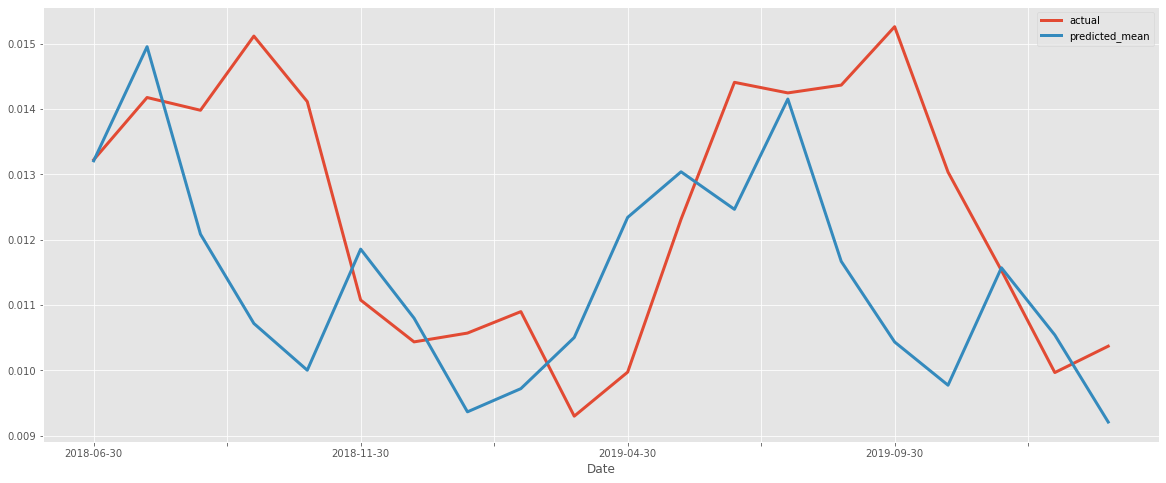

In [19]:
#SARIMAX 
predictions_nd['actual'].plot(figsize=(20,8), legend=True, linewidth=3.0)
predictions_nd['predicted_mean'].plot(legend=True, linewidth=3.0, figsize=(20,8))

ax.plot()
ax.set_title("Model Fit with Test Data", fontsize=18)
ax.set_xlabel('Date', fontsize='x-large')
ax.set_ylabel('Avg monthly kwh consumed', fontsize='x-large')
plt.legend(['Observed', 'Predicted'], loc=3, fontsize='large')
plt.savefig('images/test_pred_plot.png')

<h4>Plot predictions</h4>

/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


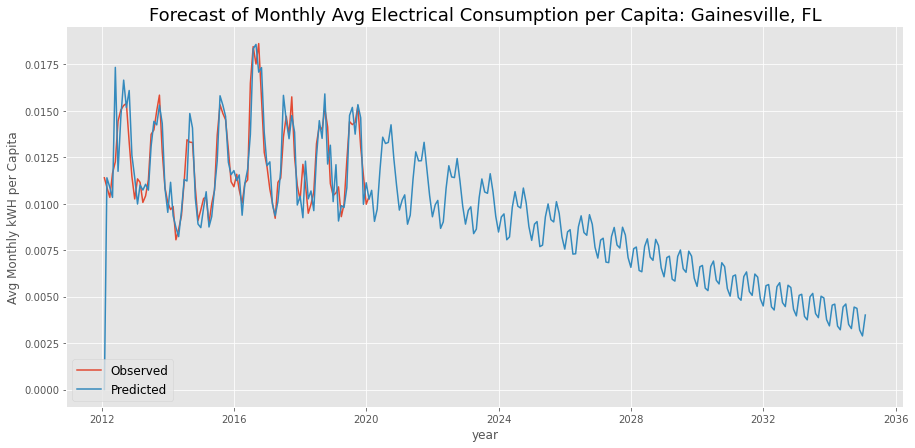

In [20]:
# Create a dataframe with index length of my prediction 
not_diffed.index = pd.to_datetime(not_diffed.index, infer_datetime_format=True)
index = pd.date_range(start='2020-02-28', end='2035-01-31', freq='M')
columns = ['avg_kwh_capita']
future_kwh = pd.DataFrame(index=index, columns=columns)

# Merge empty rediction df with the observed values df for endogenous factors in my model
future_kwh = future_kwh.merge(not_diffed, on='avg_kwh_capita', how='outer', left_index=True, right_index=True)

# Train a SARIMAX model with observed values 
e_consum_model = sm.tsa.statespace.SARIMAX(future_kwh, order=(0, 1, 2), seasonal_order=(2, 1, 1, 4)).fit()

# plot historical observations
fig, ax = plt.subplots(1, figsize=(15, 7))
ax.plot(future_kwh.index, future_kwh)

# generate predictions from the start of observed data to city goal period 
preds = e_consum_model.get_prediction(start='2012-01-31', end='2035-01-31')

ax.plot(future_kwh.index, preds.predicted_mean)
ax.set_title("Forecast of Monthly Avg Electrical Consumption per Capita: Gainesville, FL", fontsize=18)
ax.set_xlabel('year')
ax.set_ylabel('Avg Monthly kWH per Capita')
plt.legend(['Observed', 'Predicted'], loc=3, fontsize='large')
plt.savefig('images/pred_plot.png')

<h4>Plot a 95% confidence interval to 2035</h4

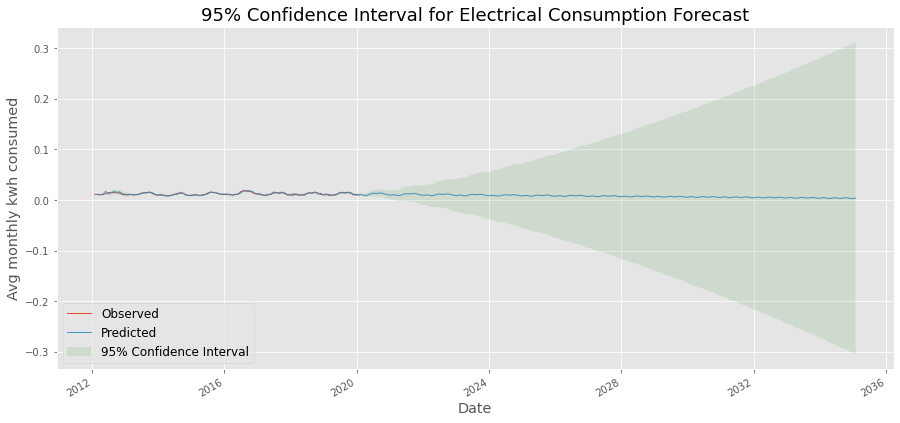

<Figure size 432x288 with 0 Axes>

In [21]:
# Generate plot of observed and predicted values with a 95% confidence interval

# specify number of forecasts
preds = e_consum_model.get_prediction(start='2012-02-28', end='2035-01-31')
pred_ci = preds.conf_int()
pred_ci = preds.conf_int()

# replace lower bound large confidence interval values with 0 to better visualize
pred_ci['lower avg_kwh_capita'][0] = 0
pred_ci['lower avg_kwh_capita'][1] = 0
pred_ci['lower avg_kwh_capita'][2] = 0
pred_ci['lower avg_kwh_capita'][3] = 0
pred_ci['lower avg_kwh_capita'][4] = 0

# replace upper bound large confidence interval values with 0 to better visualize
pred_ci['upper avg_kwh_capita'][0] = 0
pred_ci['upper avg_kwh_capita'][1] = 0
pred_ci['upper avg_kwh_capita'][2] = 0
pred_ci['upper avg_kwh_capita'][3] = 0
pred_ci['upper avg_kwh_capita'][4] = 0

ax = future_kwh['2012-01-31':].plot(label='observed', linewidth=1.0)
preds.predicted_mean.plot(ax=ax, label='Forecast', alpha=.9, figsize=(15, 7), linewidth=1.0,)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], facecolor='green', alpha=0.1)

ax.set_title("95% Confidence Interval for Electrical Consumption Forecast", fontsize=18)
ax.set_xlabel('Date', fontsize='x-large')
ax.set_ylabel('Avg monthly kwh consumed', fontsize='x-large')
plt.legend(['Observed', 'Predicted', '95% Confidence Interval'], loc=3, fontsize='large')

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('images/zoom_out_ci.png', dpi=100)

<h4>Plot a 95% confidence interval to 2022</h4

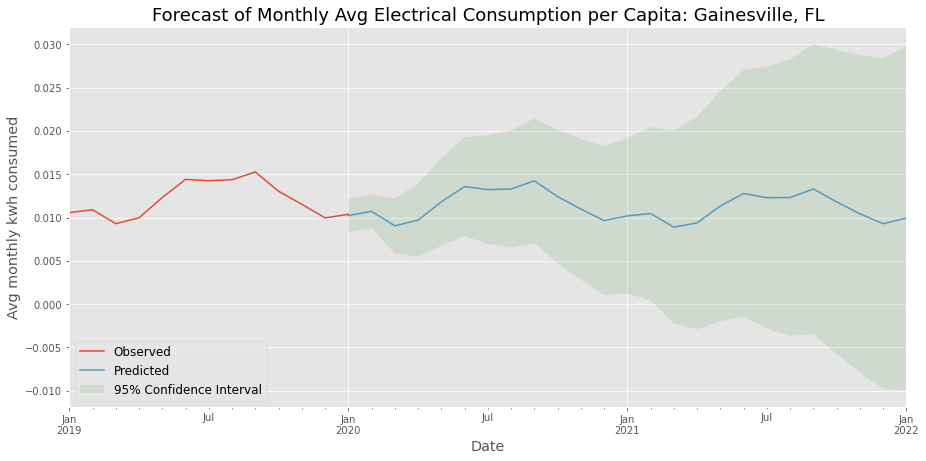

<Figure size 432x288 with 0 Axes>

In [24]:
# Zoom in where confidence interval more closely follows predictions

# specify number of forecasts
preds = e_consum_model.get_prediction(start='2020-01-31', end='2022-01-31', dynamic=False)
pred_ci = preds.conf_int()
pred_ci = preds.conf_int()


ax = future_kwh['2019-01-31': '2022-01-31'].plot(label='observed')
preds.predicted_mean.plot(ax=ax, label='Forecast', alpha=.8, figsize=(15, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], facecolor='green', alpha=0.1)

ax.set_title("Forecast of Monthly Avg Electrical Consumption per Capita: Gainesville, FL", fontsize=18)
ax.set_xlabel('Date', fontsize='x-large')
ax.set_ylabel('Avg monthly kwh consumed', fontsize='x-large')
plt.legend(['Observed', 'Predicted', '95% Confidence Interval'], loc=3, fontsize='large')

fig1 = plt.gcf()
plt.show()
plt.draw()
plt.savefig('images/zoom_in_ci.png')